<a href="https://colab.research.google.com/github/ckjen168/LLMColab/blob/main/ai_technical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI 計算技術指標

Adapted from [最強AI投資分析(旗標)](https://www.tenlong.com.tw/products/9789863127727)

In [ ]:
!pip install openai --quiet
!pip install yfinance==0.2.38 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI, OpenAIError # 串接 OpenAI API
import yfinance as yf
import pandas as pd # 資料處理套件
import datetime as dt # 時間套件

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
OPENAI_MODEL = "gpt-3.5-turbo"

In [ ]:
llm_client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

## 取得股票資料

In [ ]:
# 輸入股票代號
stock_id = "2330.tw"
# 抓取半年資料
end = dt.date.today() # 資料結束時間
start = end - dt.timedelta(days=180) # 資料開始時間
df = yf.download(stock_id, start=start, end=end).reset_index()

print(df)

[*********************100%%**********************]  1 of 1 completed

          Date    Open    High     Low   Close    Adj Close    Volume
0   2024-07-26   915.0   930.0   915.0   924.0   916.376953  82081735
1   2024-07-29   942.0   948.0   936.0   944.0   936.211914  40809258
2   2024-07-30   930.0   949.0   926.0   940.0   932.244934  41761392
3   2024-07-31   929.0   940.0   928.0   934.0   926.294495  39894991
4   2024-08-01   969.0   969.0   948.0   960.0   952.079956  47382270
..         ...     ...     ...     ...     ...          ...       ...
116 2025-01-14  1085.0  1090.0  1075.0  1090.0  1090.000000  28695247
117 2025-01-15  1085.0  1085.0  1065.0  1065.0  1065.000000  35489482
118 2025-01-16  1095.0  1115.0  1090.0  1105.0  1105.000000  47542962
119 2025-01-17  1125.0  1125.0  1095.0  1120.0  1120.000000  59214050
120 2025-01-20  1125.0  1135.0  1120.0  1120.0  1120.000000  29834528

[121 rows x 7 columns]


### 4️⃣ 創建技術指標(Techincal Analysis)提示 py_df_prompt

In [ ]:
# 呼叫OpenAI ChatCompletion
def get_reply(messages):
  try:
    response = llm_client.chat.completions.create(model=OPENAI_MODEL,
                         messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply

# 設定 AI 角色, 使其依據使用者需求進行 df 處理
def py_df_prompt(df, user_msg):

  msg = [{
    "role":
    "system",
    "content":
    f"As a professional code generation robot, \
      I require your assistance in generating Python code \
      based on specific user requirements. To proceed, \
      I will provide you with a dataframe (df) that follows the \
      format {df.columns}. Your task is to carefully analyze the \
      user's requirements and generate the Python code \
      accordingly.Please note that your response should solely \
      consist of the code itself, \
      and no additional information should be included."
  }, {
    "role":
    "user",
    "content":
    f"The user requirement:{user_msg} \n\
       Your task is to develop a Python function named \
      'calculate(df)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {df.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(df)' function \
      and exclude any unrelated content."
  }]

  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```", "")
  cleaned_code = cleaned_code.replace("python", "")

  return cleaned_code

### 讓 AI 自動生成技術指標程式碼

### 5️⃣ 計算移動平均線

In [ ]:
code_str = py_df_prompt(df, "計算8日MA與13日MA ")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['8_MA'] = df['Close'].rolling(window=8).mean()
    df['13_MA'] = df['Close'].rolling(window=13).mean()
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA
116,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308
117,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846
118,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692
119,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385
120,2025-01-20,1125.0,1135.0,1120.0,1120.0,1120.0,29834528,1096.875,1098.076923


### 6️⃣ 計算 MACD

In [ ]:
code_str = py_df_prompt(df, "先計算 EMA 再計算 MACD, 欄位名稱用 MACD_Histogram 命名")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['12_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12_EMA'] - df['26_EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram
116,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308,1091.191918,1080.839631,10.352287,12.007187,-1.654900
117,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846,1087.162392,1079.666325,7.496067,11.104963,-3.608896
118,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692,1089.906639,1081.542894,8.363746,10.556720,-2.192974
119,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385,1094.536387,1084.391568,10.144819,10.474340,-0.329521
120,2025-01-20,1125.0,1135.0,1120.0,1120.0,1120.0,29834528,1096.875,1098.076923,1098.453866,1087.029230,11.424636,10.664399,0.760237


### 7️⃣ 計算 RSI

In [ ]:
code_str = py_df_prompt(df, "計算 RSI ")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram,RSI
116,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308,1091.191918,1080.839631,10.352287,12.007187,-1.654900,52.941176
117,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846,1087.162392,1079.666325,7.496067,11.104963,-3.608896,44.736842
118,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692,1089.906639,1081.542894,8.363746,10.556720,-2.192974,54.347826
119,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385,1094.536387,1084.391568,10.144819,10.474340,-0.329521,56.250000
120,2025-01-20,1125.0,1135.0,1120.0,1120.0,1120.0,29834528,1096.875,1098.076923,1098.453866,1087.029230,11.424636,10.664399,0.760237,56.250000


### 8️⃣ 計算布林通道

In [ ]:
code_str = py_df_prompt(df, "請計算1.5個標準差的布林通道, 欄位以 Upper_Band 和 Lower_Band 命名")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['Middle_Band'] = df['Close'].rolling(window=20).mean()
    df['Std'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['Middle_Band'] + 1.5 * df['Std']
    df['Lower_Band'] = df['Middle_Band'] - 1.5 * df['Std']
    
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram,RSI,Middle_Band,Std,Upper_Band,Lower_Band
116,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308,1091.191918,1080.839631,10.352287,12.007187,-1.654900,52.941176,1085.75,20.664933,1116.747400,1054.752600
117,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846,1087.162392,1079.666325,7.496067,11.104963,-3.608896,44.736842,1085.25,21.056003,1116.834005,1053.665995
118,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692,1089.906639,1081.542894,8.363746,10.556720,-2.192974,54.347826,1086.25,21.513460,1118.520190,1053.979810
119,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385,1094.536387,1084.391568,10.144819,10.474340,-0.329521,56.250000,1088.75,22.412109,1122.368164,1055.131836
120,2025-01-20,1125.0,1135.0,1120.0,1120.0,1120.0,29834528,1096.875,1098.076923,1098.453866,1087.029230,11.424636,10.664399,0.760237,56.250000,1093.00,19.560971,1122.341456,1063.658544


### 9️⃣ 能量潮指標 (On-Balance Volumem, OBV)

In [ ]:
code_str = py_df_prompt(df, "計算 OBV 指標")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['OBV'] = (df['Volume'] * ((df['Close'] - df['Close'].shift(1)).apply(lambda x: 1 if x > 0 else -1))).cumsum()
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram,RSI,Middle_Band,Std,Upper_Band,Lower_Band,OBV
116,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308,1091.191918,1080.839631,10.352287,12.007187,-1.654900,52.941176,1085.75,20.664933,1116.747400,1054.752600,-183885746
117,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846,1087.162392,1079.666325,7.496067,11.104963,-3.608896,44.736842,1085.25,21.056003,1116.834005,1053.665995,-219375228
118,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692,1089.906639,1081.542894,8.363746,10.556720,-2.192974,54.347826,1086.25,21.513460,1118.520190,1053.979810,-171832266
119,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385,1094.536387,1084.391568,10.144819,10.474340,-0.329521,56.250000,1088.75,22.412109,1122.368164,1055.131836,-112618216
120,2025-01-20,1125.0,1135.0,1120.0,1120.0,1120.0,29834528,1096.875,1098.076923,1098.453866,1087.029230,11.424636,10.664399,0.760237,56.250000,1093.00,19.560971,1122.341456,1063.658544,-142452744


### 讓 AI 自動統整 Dataframe

### 🔟 將日頻資料轉換成月頻資料

In [ ]:
code_str = py_df_prompt(df, "請將日K線的資料轉換成月K線 ")
print(code_str)
exec(code_str)
new_df = df
df_monthly = new_df
df_monthly = calculate(df_monthly)
df_monthly.tail()

def calculate(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df_monthly = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Adj Close': 'last',
        'Volume': 'sum',
        '8_MA': 'last',
        '13_MA': 'last',
        '12_EMA': 'last',
        '26_EMA': 'last',
        'MACD': 'last',
        'Signal_Line': 'last',
        'MACD_Histogram': 'last',
        'RSI': 'last',
        'Middle_Band': 'last',
        'Std': 'last',
        'Upper_Band': 'last',
        'Lower_Band': 'last',
        'OBV': 'last'
    })
    return df_monthly


<string>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram,RSI,Middle_Band,Std,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,,
2024-09-30,950.0,1025.0,888.0,957.0,953.337158,676410210,984.250,965.384615,971.368119,956.143935,15.224184,10.661764,4.562420,65.104167,947.50,37.606690,1003.910036,891.089964,67591065
2024-10-31,967.0,1100.0,967.0,1030.0,1026.057739,792908603,1058.125,1057.307692,1046.650405,1026.149931,20.500474,25.846870,-5.346396,52.500000,1036.55,36.755916,1091.683874,981.416126,30911120
2024-11-30,996.0,1090.0,992.0,996.0,992.187927,802504052,1014.500,1022.000000,1019.498992,1027.120705,-7.621714,-1.089806,-6.531907,26.455026,1036.30,25.815336,1075.023004,997.576996,-214022308
2024-12-31,1020.0,1095.0,1015.0,1075.0,1075.000000,668020107,1077.500,1076.923077,1076.552377,1065.666422,10.885955,10.439731,0.446224,58.333333,1072.75,14.278711,1094.168066,1051.331934,-166681009
2025-01-31,1070.0,1160.0,1055.0,1120.0,1120.000000,543603393,1096.875,1098.076923,1098.453866,1087.029230,11.424636,10.664399,0.760237,56.250000,1093.00,19.560971,1122.341456,1063.658544,-142452744


## 資料視覺化

### 1️⃣1️⃣ 安裝及匯入套件

In [ ]:
import matplotlib.pyplot as plt

### 畫出簡易股價圖

### 1️⃣2️⃣ 讓我們再一次檢視資料格式吧！

In [ ]:
new_df = new_df.reset_index() # 重設 index
new_df['Date'] = pd.to_datetime(new_df['Date']) # 將 Date 轉換為 datetime 類別
new_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
116,2025-01-13,1110.0,1115.0,1070.0,1075.0,1075.0,56690300,1096.875,1092.307692,1091.306744,1079.372435,11.934309,13.192608,-1.258299,48.387097,1116.461564,1054.538436,102904648
117,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308,1091.105706,1080.159662,10.946044,12.743295,-1.797251,52.941176,1116.747400,1054.752600,131599895
118,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846,1087.089444,1079.036724,8.052720,11.805180,-3.752460,44.736842,1116.834005,1053.665995,96110413
119,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692,1089.844914,1080.959930,8.884984,11.221141,-2.336156,54.347826,1118.520190,1053.979810,143653375
120,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385,1094.484158,1083.851787,10.632371,11.103387,-0.471016,56.250000,1122.368164,1055.131836,202867425


### 1️⃣3️⃣ 使用 matplotlib 畫出收盤價的折線圖

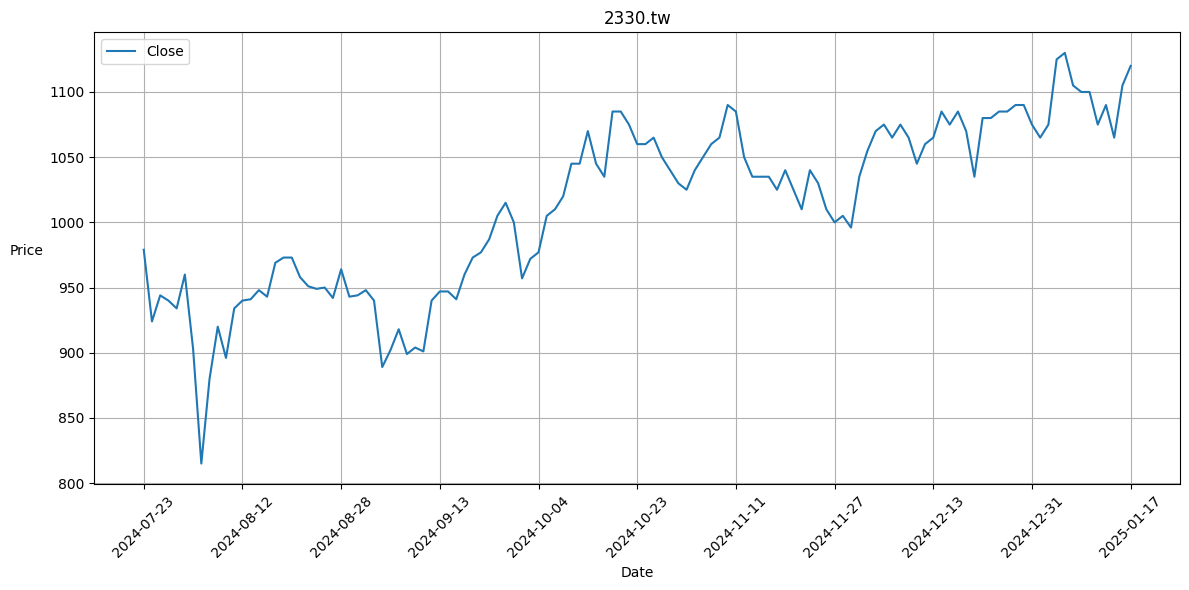

In [ ]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 6))

# 設定要繪製的資料欄位
plt.plot(new_df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num], rotation = 45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price', rotation=0, ha='right')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()

# 顯示圖表
plt.show()

### 1️⃣4️⃣ 加入成交量

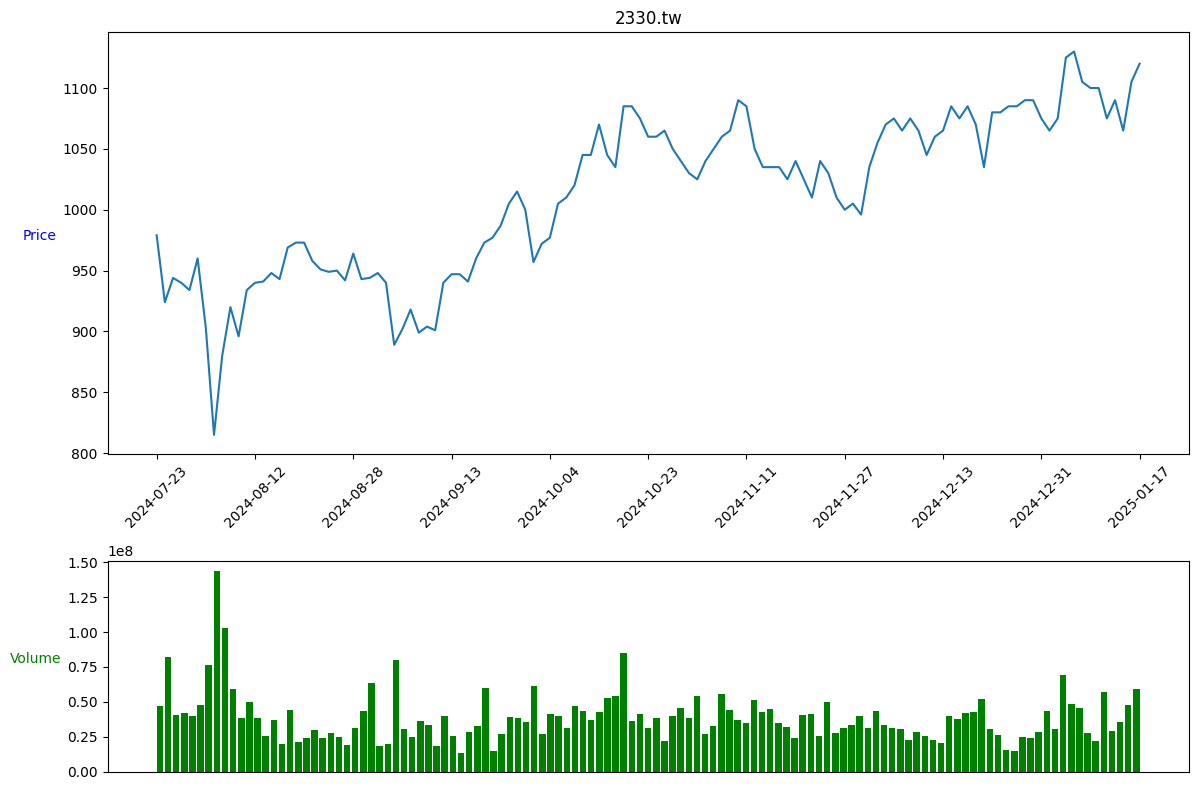

In [ ]:
# 創建兩張子圖
fig, (ax1, ax2) = plt.subplots(2, 1,
                figsize=(12, 8),
                gridspec_kw={'height_ratios': [2, 1]})

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num], rotation=45)

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'],  color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')
ax2.set_xticks([]) # 不顯示日期標籤
# 若要顯示圖表標籤可以使用以下程式碼
# ax2.set_xticks(date[::len(date)//num].index)
# ax2.set_xticklabels(date[::len(date)//num], rotation=45)

# 讓子圖填充、對齊
plt.tight_layout()

# 顯示圖表
plt.show()


### 1️⃣5️⃣ 加入技術指標

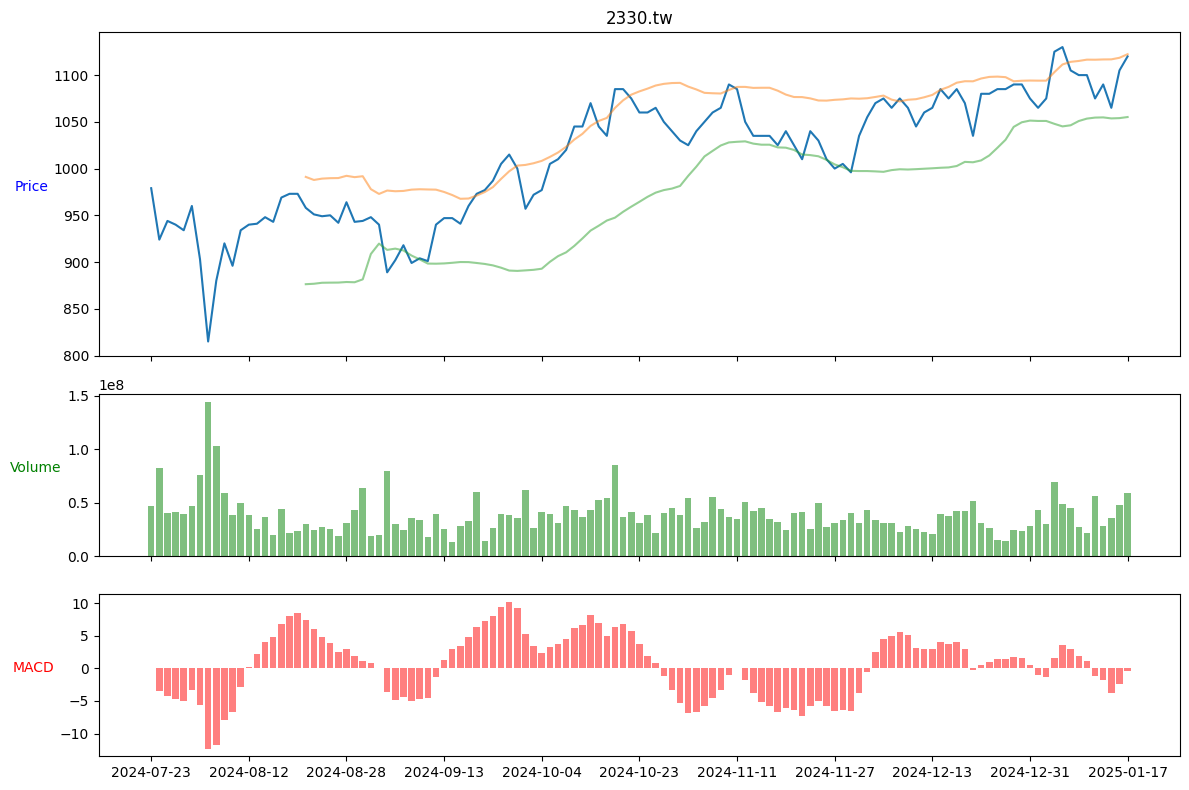

In [ ]:
# 創建三個子圖
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                    figsize=(12, 8),
                    gridspec_kw={'height_ratios': [2, 1, 1]},
                    sharex=True)

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
# 加入布林通道
ax1.plot(new_df['Upper_Band'], alpha=0.5) # alpha 設定透明度
ax1.plot(new_df['Lower_Band'], alpha=0.5)
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num])

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'], alpha=0.5, color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')

# 繪製技術指標
ax3.bar(new_df.index, new_df['MACD_Histogram'], alpha=0.5, color='red')
ax3.set_ylabel('MACD', color='red', rotation=0, ha='right')

# 調整子圖間的距離
plt.tight_layout()

# 顯示圖表
plt.show()

## plotly 互動式圖表

### 2️⃣1️⃣ 檢視資料

In [ ]:
bk_df = new_df
bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')
bk_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,8_MA,13_MA,12_EMA,26_EMA,MACD,Signal_Line,MACD_Histogram,RSI,Upper_Band,Lower_Band,OBV
Date,,,,,,,,,,,,,,,,,,
2025-01-13,2025-01-13,1110.0,1115.0,1070.0,1075.0,1075.0,56690300,1096.875,1092.307692,1091.306744,1079.372435,11.934309,13.192608,-1.258299,48.387097,1116.461564,1054.538436,102904648
2025-01-14,2025-01-14,1085.0,1090.0,1075.0,1090.0,1090.0,28695247,1100.000,1092.692308,1091.105706,1080.159662,10.946044,12.743295,-1.797251,52.941176,1116.747400,1054.752600,131599895
2025-01-15,2025-01-15,1085.0,1085.0,1065.0,1065.0,1065.0,35489482,1098.750,1091.153846,1087.089444,1079.036724,8.052720,11.805180,-3.752460,44.736842,1116.834005,1053.665995,96110413
2025-01-16,2025-01-16,1095.0,1115.0,1090.0,1105.0,1105.0,47542962,1096.250,1092.307692,1089.844914,1080.959930,8.884984,11.221141,-2.336156,54.347826,1118.520190,1053.979810,143653375
2025-01-17,2025-01-17,1125.0,1125.0,1095.0,1120.0,1120.0,59214050,1095.000,1094.615385,1094.484158,1083.851787,10.632371,11.103387,-0.471016,56.250000,1122.368164,1055.131836,202867425


### 2️⃣2️⃣ 匯入 plotly 套件

In [ ]:
import plotly.graph_objects as go

### 2️⃣3️⃣ 繪製互動式 K 線圖

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 顯示圖表
fig.show()

### 2️⃣4️⃣ 移除非交易日空值
解決繪圖不連續問題

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 移除非交易日空值
# 生成該日期範圍內的所有日期
all_dates = pd.date_range(start=bk_df.index.min(),
              end=bk_df.index.max())
# 找出不在資料中的日期
breaks = all_dates[~all_dates.isin(bk_df.index)]
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

# 顯示圖表
fig.show()

<ipython-input-21-11ede7c86549>:21: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣5️⃣ 加入懸停十字軸

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])


# 圖表更新-加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_layout(
    height=800,
    width=1200
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

<ipython-input-22-28d88b8e0393>:24: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣6️⃣ 加入技術指標

In [ ]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red', decreasing_line_color='green',
            name = "K 線")])


# 布林通道
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Upper_Band'],mode='lines',
    line={'color': 'green','dash': 'dash'},name = "上軌線"))
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Lower_Band'], mode='lines',
    line={'color': 'green', 'dash': 'dash'},name = "下軌線"))

# 交易量
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['Volume'], marker={'color': 'green'},
      yaxis='y2', name = "交易量"))

# MACD
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['MACD_Histogram'], marker={'color': 'red'},
      yaxis='y3', name = "MACD"))

# 加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="toaxis")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")

# 更新畫布大小並增加範圍選擇
fig.update_layout(
    height=800,
    yaxis={'domain': [0.35, 1]},
    yaxis2={'domain': [0.15, 0.3]},
    yaxis3={'domain': [0, 0.15]},
    title=f"{stock_id}",
    xaxis={
        # 範圍選擇格
        'rangeselector': {
            'buttons': [
                {'count': 1, 'label': '1M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 6, 'label': '6M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 1, 'label': '1Y',
                  'step': 'year', 'stepmode': 'backward'},
                {'step': 'all'}
            ]
        },
        # 範圍滑動條
        'rangeslider': {
            'visible': True,
            # 滑動條的高度 (設置 0.01 就會變單純的 bar)
            'thickness': 0.01,
            'bgcolor': "#E4E4E4"  # 背景色
        },
        'type': 'date'
    }
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

<ipython-input-23-c4952c4d4546>:69: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣7️⃣ 寫成函式

In [ ]:
# 下載資料並讓 AI 計算指標
def download_stock_data(stock_id, start=None,
                        end=None, indicator='MACD'):
    stock_id = f"{stock_id}.tw"
    if not end:
        end = dt.date.today()
    if not start:
        start = end - dt.timedelta(days=365)
    # 從 yf 下載資料
    df = yf.download(stock_id, start=start, end=end).reset_index()

    # AI 計算技術指標
    code_str = py_df_prompt(df, f"計算{indicator}")
    print(code_str)

    # 將 exec 生成的 calculate 設為局部變數
    local_vars = {}
    exec(code_str, globals(), local_vars)
    calculate = local_vars['calculate']

    df = calculate(df)

    # 資料處理
    bk_df = df.reset_index()
    bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')

    return bk_df

# 繪製圖表函式
def create_stock_figure(stock_id, bk_df):

    # 創建 K 線圖
    fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
                        open=bk_df['Open'],
                        high=bk_df['High'],
                        low=bk_df['Low'],
                        close=bk_df['Close'],
                        increasing_line_color='red',
                        decreasing_line_color='green',
                        name = "K 線")])

    # 交易量
    fig.add_trace(go.Bar(x=bk_df.index, y=bk_df['Volume'],
                         marker={'color': 'green'}, yaxis='y2',
                           name = "交易量"))

    # 找出需要繪製的欄位
    columns = bk_df.columns
    exclude_columns = ['index','Date', 'Open', 'High',
                        'Low', 'Close', 'Adj Close', 'Volume']
    remain_columns = [col for col in columns if
                       col not in exclude_columns]
    min_close = bk_df['Close'].min() - bk_df['Close'].std()
    max_close = bk_df['Close'].max() + bk_df['Close'].std()
    # 繪製技術指標
    for i in remain_columns:
      if min_close <= bk_df[i].mean() <= max_close:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', name=i))
      else:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', yaxis='y3', name=i))

    # 加入懸停十字軸
    fig.update_xaxes(showspikes=True, spikecolor="gray",
                    spikemode="toaxis")
    fig.update_yaxes(showspikes=True, spikecolor="gray",
                    spikemode="across")
    # 更新畫布大小並增加範圍選擇
    fig.update_layout(
        height=800,
        width=1200,
        yaxis={'domain': [0.35, 1]},
        yaxis2={'domain': [0.15, 0.3]},
        # 若要重疊 y1 和 y3, 可以改成
        # yaxis3=dict(overlaying='y', side='right')
        yaxis3={'domain': [0, 0.15]},
        title=f"{stock_id}",
        xaxis={
            # 範圍選擇格
            'rangeselector': {
                'buttons': [
                    {'count': 1, 'label': '1M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 6, 'label': '6M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 1, 'label': '1Y',
                      'step': 'year', 'stepmode': 'backward'},
                    {'step': 'all'}
                ]
            },
            # 範圍滑動條
            'rangeslider': {
                'visible': True,
                'thickness': 0.01,  # 滑動條的高度
                'bgcolor': "#E4E4E4"  # 背景色
            },
            'type': 'date'
        }
    )

    # 移除非交易日空值
    # 生成該日期範圍內的所有日期
    all_dates = pd.date_range(start=bk_df.index.min(),
                               end=bk_df.index.max())
    # 找出不在資料中的日期
    breaks = all_dates[~all_dates.isin(bk_df.index)]
    dt_breaks = breaks.tolist() # 轉換成列表格式
    fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

    return fig

# 主函式
def plotly_stock(stock_id, start=None, end=None, indicator='MACD'):

    df = download_stock_data(stock_id, start, end, indicator)
    fig = create_stock_figure(stock_id,df)
    fig.show()

### 2️⃣8️⃣ 執行函式

In [ ]:
plotly_stock("2317", start='2022-01-01', end= None,
             indicator='布林通道及MACD')

[*********************100%%**********************]  1 of 1 completed



import pandas as pd

def calculate(df):
    # Calculate Bollinger Bands
    df['20_DAY_SMA'] = df['Adj Close'].rolling(window=20).mean()
    df['20_DAY_STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_DAY_SMA'] + (df['20_DAY_STD'] * 2)
    df['Lower_Band'] = df['20_DAY_SMA'] - (df['20_DAY_STD'] * 2)

    # Calculate MACD
    df['26_DAY_EMA'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['12_DAY_EMA'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
    df['MACD'] = df['12_DAY_EMA'] - df['26_DAY_EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Drop intermediate columns
    df.drop(['20_DAY_SMA', '20_DAY_STD', '26_DAY_EMA', '12_DAY_EMA'], axis=1, inplace=True)

    return df



<ipython-input-24-d2ce7aac98a2>:107: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

